# SUMMARY

## CaseText

The data in treatments_list.json is a list of dicts. 
1. The full text of the case is in the "text" key of each dict
2. The date the case was decided (in unix time) is in the "decide_date" key of each dict
3. A code for the court that decided the case is in the "jurisdiction_code" key of each dict
4. The title of the case is in the "title" key of each dict
5. A list of flag codes is in the "treatments" key of each dict

The data in dissenting_opinions.csv is a csv with 3 columns that mean the following:
1. "id" an ID for that entry, probably not useful to you
2. "label" - 1 if this text comes from the end of the majority opinion of a case in which there was a dissent (more on this in a minute), or 0 if it comes from any other part of the case. 
3. "text" - the text of a part of a case

Your task will be to correctly predict when a case should have an 'r', 'v', or 'a' flag. These stand for "reversing", "vacating" or "affirming". One case can sometimes affirm in part and vacate or reverse in part. In these situations, we want the case to be given both flags that apply to it. The text where the affirming/reversing/vacating occurs is usually (but not always) at the end of the case. Where a case has a "dissenting" or "concurring" opinion, the relevant language will usually appear at the end of the "majority" opinion, right before the "dissenting" or "concurring" opinion begins.  Here is an example of text where an affirming occurs:

"Widomski failed to demonstrate that OCCC's explanation for its decision to bring disciplinary proceedings against him was pretext for retaliation. “Claims for retaliation [under the ADA] are analyzed under the same burden-shifting framework established for Title VII cases.” Treglia v. Town of Manlius, 313 F.3d 713, 719 (2d Cir.2002). For substantially the reasons set forth in the District Court's Opinion and Order entered March 21, 2013, we agree that Widomski has not produced evidence that would permit a reasonable factfinder to conclude that the initiation of disciplinary proceedings against him was a pretext for retaliation. Contarino's good faith belief that Widomski fabricated two assignments constitutes a legitimate, nonretaliatory reason for bringing a disciplinary action against him. The burden having shifted back to Widomski to provide competent evidence of pretext, Widomski fails to raise a genuine factual dispute as to whether this explanation is false or otherwise pretextual. See Weinstock v. Columbia Univ., 224 F.3d 33, 42 (2d Cir.2000). CONCLUSION We have considered Widomski's remaining arguments and conclude that they are without merit. For the foregoing reasons, the judgment of the District Court is AFFIRMED."

As I said earlier today, you probably want to use a pre-trained transformer model, though feel free to use another approach if you think it would be better. I'd suggest getting a working classifier set up using just the data from treatments_list.json before attempting to use the data in dissenting_opinions.csv to try to help further. You should be able to do reasonably well with just the data in treatments_list.json. 

## JigSaw: Toxic Online Comments

In [1]:
# The CaseText notebook was leveraged from prior NLP work on JigSaw's Kaggle competititon

In [2]:
# Kaggle: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Notebook: https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorial-04-text-classification.ipynb

# DEPENDENCIES

## Import 

In [3]:
import os
import collections
import pandas as pd
from datetime import datetime
import numpy as np
import json

## Install

In [4]:
# ktrain is a lightweight wrapper for the deep learning library Keras
# https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c
# https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c
# https://nbviewer.jupyter.org/github/amaiya/ktrain/blob/master/tutorial-04-text-classification.ipynb

!pip install ktrain 

You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import ktrain

from ktrain import text

using Keras version: 2.2.4-tf


In [6]:
ktrain.__version__

'0.7.2'

# ENVIRONMENT

## Global vars

In [7]:
## model to use
# learner_name =  'bert' 
learner_name =  'fasttext' 

## dataset to ue
data_set = 'jigsaw'
# data_set = 'casetext'

In [8]:
## path to data
NLP_ROOT = '/home/ec2-user/SageMaker/efs/NLP/'
JIGSAW_FOLDER = 'JigSaw/'
CASE_FOLDER = 'CaseText/'
JIGSAW_ROOT = NLP_ROOT + JIGSAW_FOLDER
CASETEXT_ROOT = NLP_ROOT + CASE_FOLDER

if data_set == 'jigsaw':
    NLP_ROOT = JIGSAW_ROOT
if data_set == 'casetext':
    NLP_ROOT = CASETEXT_ROOT
    
## max num of words to consider in vocabulary
NUM_WORDS = 50000

## each document can be of most <maxlen> words. 0 is used as padding ID.
MAX_LEN = 150

## batch_size based on recommendations from Google, depends on sequence_length
# https://github.com/google-research/bert/blob/master/README.md
BATCH_SIZE = 6

## proportion of training to use for validation
# if None, 10% of data will be used for validation
VAL_PCT = None 

## size of multi-word phrases to consider: 2 will consider both 1-word phrases and 2-word phrases     
NGRAM_RANGE = 1

## Dataset vars

### JigSaw

In [9]:
if data_set == 'jigsaw':
    x_col_name = 'comment_text'
    y_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    TRAIN_PATH = JIGSAW_ROOT + 'jigsaw-train.csv'
    TEST_PATH = JIGSAW_ROOT + 'jigsaw-test.csv'

### CaseText

In [10]:
# if data_set == 'casetext':
TREATMENT_PATH = CASETEXT_ROOT + 'treatments_list.json'
DISSENTING_PATH = CASETEXT_ROOT + 'dissenting_opinions.csv'

# EXTRACT

## JigSaw 

In [11]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("train=", train.shape)
print("test=", test.shape)

train= (159571, 8)
test= (153164, 2)


In [12]:
train.head()
# test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
a_text = train[x_col_name][0]
a_text

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [14]:
# Longer sequences are disproportionately expensive because attention is quadratic to the sequence length
# Publication https://github.com/google-research/bert/blob/master/README.md
# An approach https://github.com/google-research/bert/issues/27
len(a_text)

264

## CaseText

### Treatments

In [15]:
with open(TREATMENT_PATH) as json_file:
    treatments = json.load(json_file)

In [16]:
count = len(treatments)    
dic =  treatments[2]   
case_text = dic['text'] 
date = dic['decide_date']
court = dic['jurisdiction_code']
title = dic['title']
treatment = dic['treatments']
print("count=", count, "treatment=", treatment, "court=", court, "date=", date, "len=", len(case_text), "title=", title, "text=", text)

count= 10821 treatment= ['m'] court= 10th Cir. date= 1279497600000 len= 29287 title= Rocky Mountain Christian v. Board of Cty text= <module 'ktrain.text' from '/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ktrain/text/__init__.py'>


### Dissenting

In [17]:
dissenting = pd.read_csv(DISSENTING_PATH)

In [18]:
# "label": 
# - 1 if this text comes from the end of the majority opinion of a case in which there was a dissent 
# - 0 if it comes from any other part of the case.
# "text": part of the case
dissenting.head()

,id,label,text
0,101048,0,decision was not a correct interpretation of t...
1,65588,0,"agency as defined in K.R.S. 61.805, but that ..."
2,119495,0,"""appl[ied] evenhandedly to all similar claims..."
3,146601,0,egal precedents thoroughly and cogently examin...
4,101788,0,"here were. * * *"" A similar rule is followed..."


In [19]:
dissenting['text'][0]

"decision was not a correct interpretation of the intent of the original legislation.   For the above reasons, in order to resolve the ambiguities contained in the Medical Malpractice Act that are at issue in this case and to avoid disparate treatment of wrongful death claims brought pursuant to section 766.207, I believe the Medical Malpractice Act is best interpreted in conjunction with the Wrongful Death Act.   Applying the applicable provisions of the Wrongful Death Act to this case, Mrs. Barlow would be entitled to lost support and services, and her husband's estate would be entitled to Mr. Barlow's prospective net accumulations. This result makes all four scenarios for the award of damages provided for in section 766.209 consistent. It is also the result after the new statutory amendments take effect. Therefore, I believe it is the correct result in this case.    For the foregoing reasons, I respectfully dissent. "

In [20]:
dissenting['label']

0       0
1       0
2       0
3       0
4       0
5       0
6       1
7       1
8       0
9       0
10      1
11      1
12      0
13      1
14      0
15      0
16      0
17      0
18      0
19      1
20      0
21      1
22      1
23      0
24      1
25      0
26      0
27      1
28      1
29      0
       ..
9970    1
9971    0
9972    1
9973    0
9974    1
9975    0
9976    0
9977    0
9978    1
9979    1
9980    0
9981    0
9982    0
9983    0
9984    0
9985    1
9986    0
9987    0
9988    0
9989    1
9990    1
9991    1
9992    1
9993    1
9994    1
9995    1
9996    1
9997    1
9998    1
9999    0
Name: label, Length: 10000, dtype: int64

### Assemble

### Filter stop words

# TRANSFORM

## Format data for learner

In [21]:
# BERT expects input data in a specific format, 
# with special tokens to mark the beginning ([CLS]) and separation/end of sentences ([SEP]). 
# Furthermore, we need to tokenize our text into tokens that correspond to BERT’s vocabulary.
"""
x_col_name: column containing the text
y_labels: list of columns that are to be treated as labels
learner_name: 'bert', 'fasttext'
TRAIN_PATH: path to training set
TEST_PATH: path to test set
NUM_WORDS: max num of words to consider in vocabulary
MAX_LEN: each document can be of most <maxlen> words. 0 is used as padding ID.
Source: https://github.com/amaiya/ktrain/blob/7213e3ac35b71e7cad8c188a494d2b310a871d61/ktrain/text/data.py#L121
"""

### Additional texts_from_csv options:
# preprocess_mode='standard' (normal tokenization) or 'bert' tokenization and preprocessing
# encoding=None,  # auto-detected
# lang=None,      # auto-detected
# sep=',', random_state=None,       
# verbose=1

if learner_name == 'bert':
    preprocess_mode = learner_name
else:
    preprocess_mode = 'standard'

# print config    
print("TRAIN_PATH=", TRAIN_PATH, "\nVAL_PCT=", VAL_PCT, "\nx_col_name=", x_col_name, "\ny_labels=", y_labels)
print("NUM_WORDS=", NUM_WORDS, "\nMAX_LEN=", MAX_LEN, "\nNGRAM_RANGE=", NGRAM_RANGE, "\npreprocess_mode=", preprocess_mode)

TRAIN_PATH= /home/ec2-user/SageMaker/efs/NLP/JigSaw/jigsaw-train.csv 
VAL_PCT= None 
x_col_name= comment_text 
y_labels= ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
NUM_WORDS= 50000 
MAX_LEN= 150 
NGRAM_RANGE= 1 
preprocess_mode= standard


In [22]:
# return preprocessed the texts and the pre-processor    
(x_train, y_train), (x_test, y_test), pre_processor = text.texts_from_csv(train_filepath=TRAIN_PATH,
                                                                         val_pct=VAL_PCT, 
                                                                         text_column=x_col_name,
                                                                         label_columns = y_labels,
                                                                         max_features=NUM_WORDS, 
                                                                         maxlen=MAX_LEN,
                                                                         ngram_range=NGRAM_RANGE,
                                                                         preprocess_mode=preprocess_mode
                                                                         )

detected encoding: utf-8 (if wrong, set manually)
language: en
Word Counts: 175893
Nrows: 119678
119678 train sequences
Average train sequence length: 66
x_train shape: (119678,150)
y_train shape: (119678,6)
39893 test sequences
Average test sequence length: 66
x_test shape: (39893,150)
y_test shape: (39893,6)


## Explore Transformed Input Data

In [23]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,   78,    5,
        389,  209,   26,   11,  155, 1849,   49,   30, 3903,    4,   11,
        155,  201,  596,   54,  272,  178,  107], d

In [24]:
y_train

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [25]:
n_classes = len(y_labels)
n_classes

6

In [26]:
# dir(pre_processor)

# TRANSFER LEARNING

## KTrain

In [27]:
# available classifiers
text.print_text_classifiers()

fasttext: a fastText-like model (http://arxiv.org/pdf/1607.01759.pdf)
logreg: logistic regression using a trainable Embedding layer
nbsvm: NBSVM model (http://www.aclweb.org/anthology/P12-2018)
bigru: Bidirectional GRU with pretrained word vectors (https://arxiv.org/abs/1712.09405)
standard_gru: simple 2-layer GRU with randomly initialized embeddings
bert: Bidirectional Encoder Representations from Transformers (https://arxiv.org/abs/1810.04805)


## Instantiate learner

In [28]:
"""    
Instantiate a classifier, and wrap it in a learner with data
"""

# load a pretrained model with a randomly initialized final Dense layer
# freeze_layers=80
# Source: https://github.com/amaiya/ktrain/blob/7213e3ac35b71e7cad8c188a494d2b310a871d61/ktrain/text/learner.py#L14
model = text.text_classifier(name=learner_name, 
                             train_data=(x_train, y_train), 
                             preproc=pre_processor)

Is Multi-Label? True
compiling word ID features...
maxlen is 150
done.


In [29]:
"""    
Wrap a classifier in a learner with data
"""

# wrap model and data in ktrain.Learner object
# workers=1, use_multiprocessing=False, multigpu=False
learner = ktrain.get_learner(model=model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test),
                             batch_size=BATCH_SIZE)

# TRAIN

## Learning Rate

In [30]:
# Reference: https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c
# Notebook: https://github.com/amaiya/ktrain/blob/master/tutorial-02-tuning-learning-rates.ipynb

In [31]:
# briefly simulate training
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
  8664/119678 [=>............................] - ETA: 5:32 - loss: 0.6401 - acc: 0.6495

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


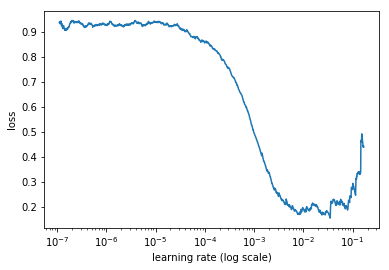

In [32]:
# visually identify best learning rate
learner.lr_plot()

In [33]:
# Thus use learning rate 
learning_rate = 7 * pow(10, -4)
num_epoch = 1
print("will use: ", "learning_rate=", learning_rate, "num_epoch=", num_epoch)

will use:  learning_rate= 0.0007 num_epoch= 1


## Fit

In [34]:
# Many fit options: https://towardsdatascience.com/ktrain-a-lightweight-wrapper-for-keras-to-help-train-neural-networks-82851ba889c
# 1cycle learning rate policy that linearly increases the learning rate for the first half of training 
# and then decreases the learning rate for the latter half:

learner.autofit(learning_rate, num_epoch)



begin training using triangular learning rate policy with max lr of 0.0007...
Train on 119678 samples, validate on 39893 samples
119678/119678 [==============================] - 358s 3ms/sample - loss: 0.1308 - acc: 0.9550 - val_loss: 0.0652 - val_acc: 0.9785


# EVALUATE

## ROC, AUC Functions

In [35]:
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score


In [36]:
def class_performance_aggregation(y_test, y_score, n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    return roc_auc, fpr, tpr

In [37]:
def multiclass_performance_aggregation(fpr, tpr, n_classes):
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Compute macro-average ROC curve and ROC area    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return roc_auc, fpr, tpr

In [38]:
def plot_multiclass_performance(fpr, tpr, roc_auc, n_classes):
    
    plt.figure()
    line_width = 2
    
#     plt.plot(fpr["micro"], tpr["micro"],
#              label='micro-average ROC curve (area = {0:0.2f})'
#                    ''.format(roc_auc["micro"]),
#              color='deeppink', linestyle=':', linewidth=4)

#     plt.plot(fpr["macro"], tpr["macro"],
#              label='macro-average ROC curve (area = {0:0.2f})'
#                    ''.format(roc_auc["macro"]),
#              color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

## Class evaluation

In [39]:
y_pred = learner.model.predict(x_test, verbose=0)
auc_score = roc_auc_score(y_test, y_pred)

print("Receiver Operating Characteristic: Area Under the Curve score: %.6f" % (auc_score))

Receiver Operating Characteristic: Area Under the Curve score: 0.953205


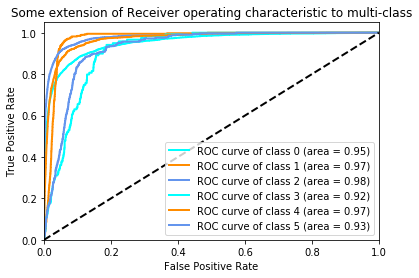

In [40]:
roc_auc, fpr, tpr = class_performance_aggregation(y_test, y_pred, n_classes)

roc_auc, fpr, tpr = multiclass_performance_aggregation(fpr, tpr, n_classes)

plot_multiclass_performance(fpr, tpr, roc_auc, n_classes)

# PREDICT

In [41]:
predictor = ktrain.get_predictor(learner.model, pre_processor)

# ERROR ANALYSIS

In [42]:
input_texts = {}
pred_dictions = {}

In [43]:
if data_set == 'jigsaw':
    input_texts[0] = ["If you don't stop immediately, I will kill you."]
    input_texts[1] = ["Okay - I'm calling it a night. See you tomorrow."]
    input_texts[2] = ["You have a really ugly face."]
if data_set == 'casetext':
    input_texts[0] = ["Widomski failed to demonstrate that OCCC's explanation for its decision to bring disciplinary proceedings against him was pretext for retaliation. “Claims for retaliation [under the ADA] are analyzed under the same burden-shifting framework established for Title VII cases.” Treglia v. Town of Manlius, 313 F.3d 713, 719 (2d Cir.2002). For substantially the reasons set forth in the District Court's Opinion and Order entered March 21, 2013, we agree that Widomski has not produced evidence that would permit a reasonable factfinder to conclude that the initiation of disciplinary proceedings against him was a pretext for retaliation. Contarino's good faith belief that Widomski fabricated two assignments constitutes a legitimate, nonretaliatory reason for bringing a disciplinary action against him. The burden having shifted back to Widomski to provide competent evidence of pretext, Widomski fails to raise a genuine factual dispute as to whether this explanation is false or otherwise pretextual. See Weinstock v. Columbia Univ., 224 F.3d 33, 42 (2d Cir.2000). CONCLUSION We have considered Widomski's remaining arguments and conclude that they are without merit. For the foregoing reasons, the judgment of the District Court is AFFIRMED."]

In [44]:
for k, v in input_texts.items():
    prediction = predictor.predict(v)
    print("prediction=", prediction)
    pred_dictions[k] = prediction

prediction= [[('toxic', 0.8339252), ('severe_toxic', 0.2443017), ('obscene', 0.6705859), ('threat', 0.13042082), ('insult', 0.5856317), ('identity_hate', 0.17763926)]]
prediction= [[('toxic', 0.08226959), ('severe_toxic', 0.00024394026), ('obscene', 0.01626463), ('threat', 0.00049809605), ('insult', 0.023578612), ('identity_hate', 0.003449192)]]
prediction= [[('toxic', 0.65548146), ('severe_toxic', 0.049851224), ('obscene', 0.3592043), ('threat', 0.020304885), ('insult', 0.3235748), ('identity_hate', 0.088493735)]]


In [45]:
for i in range(len(input_texts)):  
    print(i, "input_texts=", input_texts[i])
    print(i, "predictions=", pred_dictions[i])

0 input_texts= ["If you don't stop immediately, I will kill you."]
0 predictions= [[('toxic', 0.8339252), ('severe_toxic', 0.2443017), ('obscene', 0.6705859), ('threat', 0.13042082), ('insult', 0.5856317), ('identity_hate', 0.17763926)]]
1 input_texts= ["Okay - I'm calling it a night. See you tomorrow."]
1 predictions= [[('toxic', 0.08226959), ('severe_toxic', 0.00024394026), ('obscene', 0.01626463), ('threat', 0.00049809605), ('insult', 0.023578612), ('identity_hate', 0.003449192)]]
2 input_texts= ['You have a really ugly face.']
2 predictions= [[('toxic', 0.65548146), ('severe_toxic', 0.049851224), ('obscene', 0.3592043), ('threat', 0.020304885), ('insult', 0.3235748), ('identity_hate', 0.088493735)]]


# MODEL SAVE, LOAD

In [46]:
predictor.save(NLP_ROOT + 'multilabel_detector')
predictor = ktrain.load_predictor(NLP_ROOT + 'multilabel_detector')

In [47]:
predictor.predict(input_texts[0])

[[('toxic', 0.8339252),
  ('severe_toxic', 0.2443017),
  ('obscene', 0.6705859),
  ('threat', 0.13042082),
  ('insult', 0.5856317),
  ('identity_hate', 0.17763926)]]

# REFERENCES

In [48]:
# Blog: IMDB https://towardsdatascience.com/bert-text-classification-in-3-lines-of-code-using-keras-264db7e7a358
# Demo: IMDB https://colab.research.google.com/drive/18SVeIFXWCiA9HL4WVCAFxlfH59ez6atc#scrollTo=p5lJ5jXpqtM9
# Demo: Newsgroup https://colab.research.google.com/drive/1AH3fkKiEqBpVpO5ua00scp7zcHs5IDLK